In [1]:
# imports and define some constants
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import math
import scipy.signal
from ipy_table import *
h = constants.h
c = constants.c
k = constants.k
sb = constants.Stefan_Boltzmann


## Measuring Power

We measure the power by sampling the voltage that is across a resitive load.  We will measure this power at different frequencies, but to start, consider a source that is generating power at frequency $\nu_0$ and power level $P_0$.  

### Ohms Law and Power Dissipation 

A steady voltage $V$ applied to a resistance $R$ draws current $I$ (Ohm's law:  $V = IR$) and
dissipates power $P = IV$.  Substitute $I=V/R$ to get $P = V^2/R$, the power dissipated in a resistance by a steady voltage.

For an alternating voltage, $R$ is a measure of the impedance of the circuit.  A common value of the impedance is 50 ohms.  

### Measure the voltage
When we look on an oscilloscope, we see a sine wave of frequency $\nu_0$.  There are three ways the characterize how large the signal is:

* $V_{PP}$ -- peak-to-peak voltage 
* $V_{P}$ -- peak voltage
* $V_{RMS}$ -- root mean square voltage.

These are related by 

$$ V_{RMS} = \frac{1}{\sqrt{2}} V_{P} = \frac{1}{2\sqrt{2}} V_{PP} $$

Since power is proportional to $V^2$, so we will use

$$ V^2_{RMS} = \frac{1}{2} V^2_{P} = \frac{1}{8} V^2_{PP} $$

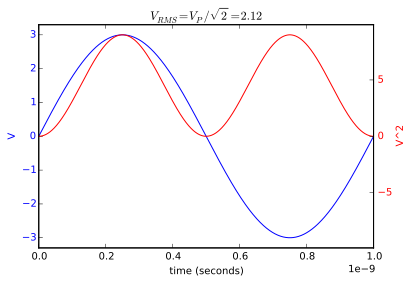

In [2]:
# Pick a frequency
nu = 1e9 # Frequency is 1 GHz
period = 1/nu

# Sample times for one period
t = np.linspace(0, period, 1000, endpoint=False)

# Choose the peak voltage
v_p = 3 # Peak voltage is 3 Volts

# Calculate sine wave
v = v_p*np.sin(2*np.pi*t*nu)

# Here is voltage squared
v2 = np.power(v,2)

# Calculate the root mean square of voltage.
# 1. square each voltage  
# 2. take the mean of those values  
# 3. take the sqrt of the mean
vrms = math.sqrt(v2.mean())


fig, ax1 = plt.subplots()
ax1.plot(t,v, color='b')
ax1.set_ylabel('V', color='b')
ax1.set_ylim((-1.1*v_p, 1.1*v_p))
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(t, v2, 'r')
ax2.set_ylabel('V^2', color='r')
ax2.set_ylim((-1.1*v_p**2, 1.1*v_p**2))
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax1.set_xlabel("time (seconds)")

t = ax1.set_title("$V_{RMS}  = V_P/\sqrt{2} = %.2f$"%(vrms))

We verified the formula $V_{RMS} = V_P/\sqrt{2}$ numerically.  We can also do the integral symbolically in python.

The definition is
$$ V_{RMS} = \sqrt{ \frac{\int_0^{2\pi} [V_P \sin(x)]^2) dx}{\int_0^{2\pi} dx} } $$

In [3]:
# Calculus using sympy
from sympy import *
x = Symbol('x', positive=True)
vp = Symbol('vp', positive=True)
num = integrate( (vp*sin(x))**2, (x, 0, 2*pi))
den = integrate(      1        , (x, 0, 2*pi))
print " num =",num
print " den =",den
vrms = sqrt(num/den)
print "vrms =",vrms

 num = pi*vp**2
 den = 2*pi
vrms = sqrt(2)*vp/2


### Power Spectrum
This example used a simple signal, defined to have one frequency.  It is more interesting to deal with many different frequencies at the same time.  The signal voltage $V_n$ is a list of $N$ measurements of the voltage.  These are measured at the sampling rate $\nu_S$ Hz.  The time between the samples $V_0$ and $V_1$ is the sampling time $\tau_S = 1/\nu_S$ seconds.

Using Euler's formula $$e^{i\phi} = \cos{\phi} + i \sin{\phi} $$

we use this equation to express the $N$ measured values of $V$:
$$ V_n = \frac{1}{N} \sum_{k=0}^{N-1} \tilde{V}_k e^{2\pi i k n/N} $$
There is a huge difference between $V_n$ and $\tilde{V}_k$:
* $V_n$ is the measured voltage at the time defined by $n$;
* $\tilde{V}_k$ is the amplitude and phase of a sine wave at the frequency defined by $k$.

The trick is to find the values of $\tilde{V}_k$ that add up sine waves to restore the measured values $V_n$.  In principle you could do this with a massive data fitting program, but there is a much better way.  The Fast Fourier Transform does is much more efficiently.  There is a nice python program to do this for us.  Here is an example of a signal that is two sine waves, one at 100 kHz with $V_{RMS}$ = 100 mV, and a second at 1 MHz with $V_{RMS}$ = 50 mV.  This will show up as a small, fast ripple on a slow sine wave.



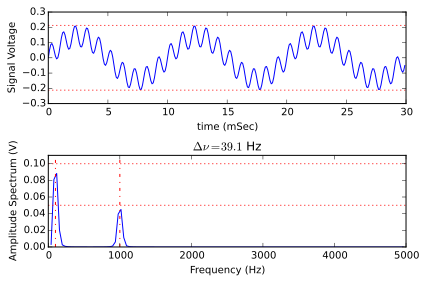

In [4]:
nus = 10e3 # sample at 10 MHz.
ns = 256 # Number of sampled used for each power spectrum calculation

# The first sine wave
vRms1 = 0.1
vPeak1 = vRms1 *np.sqrt(2)
nu1   = 100.0

# The second sine wave
vRms2 = 0.05
vPeak2 = vRms2 * np.sqrt(2)
nu2   = 1000.0

# How long will it take for 3 complete cycles of the first sine wave
tExposure = 3/nu1
nData = tExposure*nus
times = np.linspace(0, tExposure, nData, endpoint=False)
signal = vPeak1*np.sin(2*np.pi*times*nu1) + vPeak2*np.sin(2*np.pi*times*nu2)

# Plot the signal as a function of time
plt.subplot(211)
plt.plot(times/1e-3, signal)
plt.xlabel("time (mSec)")
plt.ylabel("Signal Voltage")
# Mark the expected maximum and minimum voltages
plt.axhline(vPeak1+vPeak2, color='r', linestyle=":")
plt.axhline(-vPeak1-vPeak2, color='r', linestyle=":")

# Calculate the power spectrum
f,pxx = scipy.signal.welch(signal, fs=nus, nperseg=ns, scaling='spectrum') # note the scaling

# Plot the power spectrum
plt.subplot(212)
plt.plot(f[1:-1], np.sqrt(pxx[1:-1])) # Skip the first and last frequency bins
plt.ylim(ymax=1.1*vRms1)
# Mark the height of the two sine waves
plt.axhline(vRms1, color='r', linestyle=":")
plt.axhline(vRms2, color='r', linestyle=":")
# Mark the frequencies of the two sine waves
plt.axvline(nu1, color='r', linestyle="-.")
plt.axvline(nu2, color='r', linestyle="-.")
plt.title("$\Delta \\nu = %.1f$ Hz"%(nus/ns))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude Spectrum (V)")
plt.tight_layout()

The first plot shows the input voltage signal.  The horizontal lines mark the maximum and minimum values.  The bottom plot shows the spectrum, with only two features, at 100 Hz and 1000 Hz, as the vertical lines show.  The amplitudes are almost correct, just under 0.1 and 0.05 volts.  More on that later, but first, let's worry about the frequency measurement.

Notice that the scale on the spectrum goes up to 5000 Hz, half the sampling frequency.  This is referred to as the Nyquist frequency.  The maximum frequency measured ($\nu_{NY}$) is related to the sampling frequency ($\nu_S$) by
$$\nu_{NY} = \frac{1}{2} \nu_S$$

What happens if we input a signal above $\nu_{NY}$?  In this example, $\nu_{NY}$ = 5000 Hz.  Let's repeat the above examples, but with frequencies 5100 Hz and 6000 Hz.

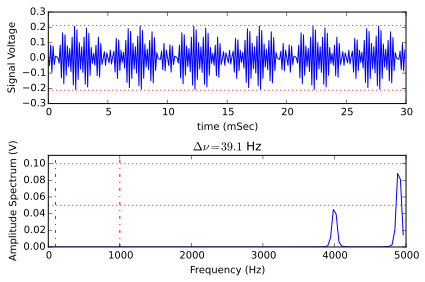

In [5]:
nus = 10e3 # sample at 10 MHz.
ns = 256 # Number of sampled used for each power spectrum calculation

# The first sine wave
vRms1 = 0.1
vPeak1 = vRms1 *np.sqrt(2)
nu1   = 100.0

# The second sine wave
vRms2 = 0.05
vPeak2 = vRms2 * np.sqrt(2)
nu2   = 1000.0

# How long will it take for 3 complete cycles of the first sine wave
tExposure = 3/nu1
nData = tExposure*nus
times = np.linspace(0, tExposure, nData, endpoint=False)
## Add 5000 to both frequencies
signal = vPeak1*np.sin(2*np.pi*times*(nu1+5000)) + vPeak2*np.sin(2*np.pi*times*(nu2+5000))

# Plot the signal as a function of time
plt.subplot(211)
plt.plot(times/1e-3, signal)
plt.xlabel("time (mSec)")
plt.ylabel("Signal Voltage")
# Mark the expected maximum and minimum voltages
plt.axhline(vPeak1+vPeak2, color='r', linestyle=":")
plt.axhline(-vPeak1-vPeak2, color='r', linestyle=":")

# Calculate the power spectrum
f,pxx = scipy.signal.welch(signal, fs=nus, nperseg=ns, scaling='spectrum') # note the scaling

# Plot the power spectrum
plt.subplot(212)
plt.plot(f[1:-1], np.sqrt(pxx[1:-1])) # Skip the first and last frequency bins
plt.ylim(ymax=1.1*vRms1)
# Mark the height of the two sine waves
plt.axhline(vRms1, color='r', linestyle=":")
plt.axhline(vRms2, color='r', linestyle=":")
# Mark the frequencies of the two sine waves
plt.axvline(nu1, color='r', linestyle="-.")
plt.axvline(nu2, color='r', linestyle="-.")
plt.title("$\Delta \\nu = %.1f$ Hz"%(nus/ns))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude Spectrum (V)")
plt.tight_layout()

What happened?  The peaks do not show up at the correct frequency -- or do they?  

The highest frequency possible for the Fourier Transform to measure is the Nyquist Frequency:  $\nu_{Ny} = \nu_S/2$.  Frequencies higher than that "reflect" from $\nu_{Ny}$.  In this example:

* the signal at $\nu_1 = 5100 $ Hz appears at $2\nu_{Ny} - 5100 = 4900$ Hz, and  
* the signal at $\nu_2 = 6000 $ Hz appears at $2\nu_{Ny} - 6000 = 4000$ Hz.  

That only works up to the sampling frequency.  Above that, the location "reflect" again from $\nu = 0$.  

For all frequencies, the measured frequency of a signal, as a function of the actual frequency, looks like this:

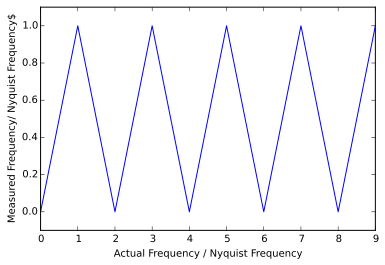

In [6]:
n = 10
fActual = np.arange(n)
fObserved = np.mod(fActual, 2)
plt.plot(fActual, fObserved)
plt.ylim((-0.1, 1.1))
plt.xlabel("Actual Frequency / Nyquist Frequency")
l = plt.ylabel("Measured Frequency/ Nyquist Frequency$")


When we use a signal generator, the strength of the signal is defined in dBm, where

$$dBm = 10 log_{10}(\frac{P}{10^{-3}})$$

The signal generator drives an impedance of 50 Ohms, so using $V=IR$ and $P=IV$ we get

$$ P = \frac{V_{RMS}^2}{R} $$

To convert between dBm and $V_{RMS}$:

$$dBm = 10 log_{10}(\frac{V_{RMS}^2}{50 \times 10^{-3}})$$

and

$$ V_{RMS}^2 = 50 \times 10^{-3} R 10^{dBm/10} $$

Here are two functions that do this:

In [7]:
def dbmToWatts(dbm):
    return 1e-3 * math.pow(10,dbm/10.0)
def dbmToVrms(dbm, r=50):
    return math.sqrt(r * 1e-3 * math.pow(10,dbm/10.0))
def vrmsToDbm(vrms, r=50):
    return 10*math.log10(vrms**2/(r*1e-3))
def vrmsToVp(vrms):
    return math.sqrt(2)*vrms
def vpToVrms(vp):
    return vp/math.sqrt(2)

# Duplicate this table:  http://ifmaxp1.ifm.uni-hamburg.de/DBM.shtml
lines = [['dBm', "Watts","Volts rms","Volts peak", "Volts pp"]]
for dbm in range(-180, 40, 10):
    # Test that converting back and forth returns the same number
    dbm0 = vrmsToDbm(dbmToVrms(dbm))
    assert abs(dbm-dbm0) < 1e-6, "hello:  dbm=%f dbm0=%f"%(dbm,dbm0)   
    lines.append([dbm, dbmToWatts(dbm), dbmToVrms(dbm), vrmsToVp(dbmToVrms(dbm)), 2*vrmsToVp(dbmToVrms(dbm))])
make_table(lines)
apply_theme('basic')
set_global_style(float_format='%.2e')

dBm,Watts,Volts rms,Volts peak,Volts pp
-180,1.00e-21,2.24e-10,3.16e-10,6.32e-10
-170,1.00e-20,7.07e-10,1.00e-09,2.00e-09
-160,1.00e-19,2.24e-09,3.16e-09,6.32e-09
-150,1.00e-18,7.07e-09,1.00e-08,2.00e-08
-140,1.00e-17,2.24e-08,3.16e-08,6.32e-08
-130,1.00e-16,7.07e-08,1.00e-07,2.00e-07
-120,1.00e-15,2.24e-07,3.16e-07,6.32e-07
-110,1.00e-14,7.07e-07,1.00e-06,2.00e-06
-100,1.00e-13,2.24e-06,3.16e-06,6.32e-06
-90,1.00e-12,7.07e-06,1.00e-05,2.00e-05


In this example, we know that the signals are at specific frequencies, they are line spectra.  We can use this to see where the observed frequency winds up being measured, based on the Nyquist frequency.

## Continuous Spectra

We want to measure a continuous spectrum, where there is some power at every frequency.  To do this correctly we need to make two changes.

First, when we use the Welch method to calculate the spectrum, use "scaling=density" to return the spectrum in units of power per frequency.  This way, the spectrum will have the same magnitude if we measure it with a different resolution in frequency.

Second, we need to watch out for frequencies larger than the Nyquist frequency:  they will reflect back and be double counted.  We do this by applying a filter to input signal before calculating the spectrum. (Guess what -- python has programs to do this!)

### Thermal Noise

A convenient source of a continuous spectrum is a resistor!  Look up "Johnson-Nyquist noise" for details, but here is what happens.  When a resistor of resistance $R$ is at a temperature $T$, the voltage measured across it varies, with 
$$ V_{RMS} = 2\sqrt{kTR\Delta \nu} $$
where:
* $V_{RMS}$ is the RMS of the voltages
* $T$ is the temperature in Kelvin
* $R$ is the resistance in Ohms
* $\Delta \nu$ is the bandwidth.

The bandwidth is the width of each frequency bin in the power spectrum. It depends on the sample frequency $\nu_S$, and on $N_S$, the number of data points we use to calculate the power spectrum:
$$\Delta \nu = \nu_S/N_S$$



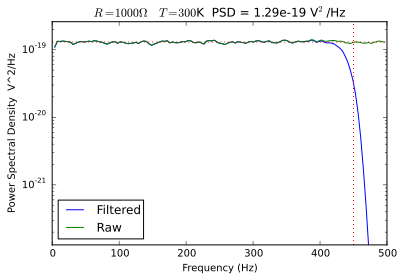

In [8]:
tKelvin = 300
rOhm = 1000
sampleRate = 1e3
nperseg = 256
fNyquist = sampleRate/2.0
fCritical = 450

dNu = sampleRate/nperseg
vSigma = np.sqrt(4*k*tKelvin*rOhm*dNu)
psdExpected = vSigma**2/fNyquist
np.random.seed(123454321)
n = 100000
vRaw = np.random.normal(size=n, scale=vSigma)
# Define a filter that allows frequencies < fCritical
order = 3
b, a = scipy.signal.butter(order, fCritical/fNyquist, btype='low')
vFiltered = scipy.signal.filtfilt(b, a, vRaw)

# Calculate the power spectrum
f,pxxFiltered = scipy.signal.welch(vFiltered, fs=sampleRate, scaling='density', nperseg=nperseg) # note the scaling
f,pxxRaw = scipy.signal.welch(vRaw, fs=sampleRate, scaling='density', nperseg=nperseg) # note the scaling
plt.semilogy(f[1:-1], pxxFiltered[1:-1], label="Filtered")
plt.semilogy(f[1:-1], pxxRaw[1:-1], label="Raw")
plt.axvline(fCritical, color='r', linestyle=":")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density  V^2/Hz")
plt.axhline(psdExpected, color='r', linestyle=":")
plt.legend(loc="lower left")
plt.ylim(psdExpected/1e3, psdExpected*2)
asdNv = np.sqrt(psdExpected)/1e-9
t = plt.title("$R = %d \Omega$   $T=%d$K  PSD = %.2e V$^2$/Hz"%(rOhm, tKelvin, psdExpected))

Another source of continuous noise is digitization.  The least significant bit (LSB) of a number corresponds to a voltage.  When a signal is digitized with this resolution, the noise background is:

$$V_{D} = \frac{V_{LSB}}{\sqrt{6 \nu_S}} $$
Here is an example.

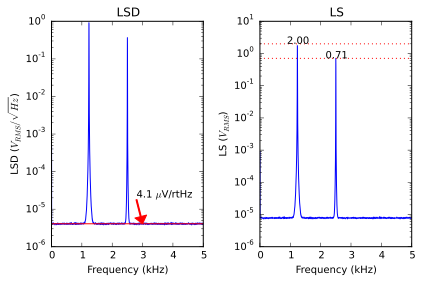

In [9]:
import numpy as np
fs = 10000;
f1 = 1234;
amp1 = 2.82842712474619;
f2 = 2500.2157;
amp2 = 1;
ulsb = 1e-3;
n = 1000000

t = np.linspace(0, n/float(fs), num=n, endpoint=False)
vRaw = amp1 * np.sin(2*np.pi*f1*t) + amp2 * np.sin(2*np.pi*f2*t)
vDigitized = np.floor(vRaw/ulsb + 0.5)*ulsb

nperseg = 4096
f,psd = scipy.signal.welch(vDigitized, fs=fs, scaling='density', nperseg=nperseg)
f,ps = scipy.signal.welch(vDigitized, fs=fs, scaling='spectrum', nperseg=nperseg)
plt.subplot(121)
plt.semilogy(f[1:-1]/1e3,np.sqrt(psd[1:-1]))
vd = ulsb/np.sqrt(6*fs)
plt.axhline(vd, color='r')
plt.title("LSD")
plt.xlabel("Frequency (kHz)")
plt.ylabel("LSD ($V_{RMS}/\sqrt{Hz}$)")
plt.annotate("%.1f $\mu$V/rtHz"%(vd/1e-6), xy=(3,vd), xytext=(2.8, vd*5),
            arrowprops=dict(facecolor='red', width=1, frac=.3, edgecolor='red'),
            )
plt.subplot(122)
plt.semilogy(f[1:-1]/1e3, np.sqrt(ps[1:-1]))
plt.title("LS")
plt.xlabel("Frequency (kHz)")
plt.ylabel("LS ($V_{RMS}$)")
plt.axhline(amp1/np.sqrt(2), color='r', linestyle=":")
plt.axhline(amp2/np.sqrt(2), color='r', linestyle=":")
plt.text(f1/1e3, amp1/np.sqrt(2), "%.2f"%(amp1/np.sqrt(2)), horizontalalignment='center')
plt.text(f2/1e3, amp2/np.sqrt(2), "%.2f"%(amp2/np.sqrt(2)), horizontalalignment='center')
plt.tight_layout()

### Mimic Johnson Noise at one temperature

With the signal generator, choose a frequency and amplitude that will simulate the thermal noise of a resistor $R$ at temperature $T$ in one frequency bin.

The voltage noise is $$ V_{RMS} = 2\sqrt{kTR\Delta \nu} $$

Where

$$\Delta \nu = \frac{\nu_S}{N_S}$$

where
* $\nu_S$ is the sampling frequency
* $N_S$ is the numer of samples per segment used to calculate the power spectrum

so 

$$ dBm = 10 \log_{10}{\large[}{\frac{4kT}{10^{-3}}\frac{\nu_S}{N_S}}{\large]} $$

With a sampling rate $\nu_S$ = 10 MHz, calculating the power spectra with $N_S = 1024$, a 50-Ohm load will see this:


In [10]:
nus = 10e6
ns = 1024
lines = [["T (K)","Description","dBm","V Peak (nV)"]]
tdList = [[77, "Liquid Nitrogen"], [273, "Ice"], [293, "Room Temperature"], [373, "Boiling Water"]]
for t,description in tdList:
    dbm = 10*np.log10((4*k*t*nus)/(1e-3*ns))
    vPeak = vrmsToVp(dbmToVrms(dbm))
    lines.append([t, description, dbm, vPeak/1e-9])
make_table(lines)
apply_theme('basic')
set_global_style(float_format='%.1f')

T (K),Description,dBm,V Peak (nV)
77,Liquid Nitrogen,-133.8,64.4
273,Ice,-128.3,121.3
293,Room Temperature,-128.0,125.7
373,Boiling Water,-127.0,141.8
